In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

### Description of the data

- Government response
    - Stringency (C1 - C8): school closing, restrictions on gatherings etc.
    - Containment health (C1 - C8, H1 - H3): stringency + information, testing, contract tracing
    - Government response (C1 - C8, E1 - E2, H1 - H3):  containment + income support, debt contract relief
    - Economic support (E1 - E2 only)
    - Not used (E3 - E4, H4 - H5, M1)

- Cultural factors
    - PDI: extent to which the less powerful members accept that power is distributed unequally, higher value = hierarchy is clearly established and executed in society, without doubt or reason
    - IDV: degree to which people in a society are integrated into groups
    - UAI: a society's tolerance for ambiguity
    - MAS: preference in achievement for heroism, assertiveness and material rewards for success
    - LTO: high = more oriented to the future/ being more pragmatic, less on past traditions
    - IND: measure of happiness; if simple joys are fulfilled

### Data preparation

In [2]:
df_govt_raw = pd.read_csv("Data/00 Core/Oxford Covid-19 Government Response Tracker/OxCGRT_latest.csv")
cols = [col for col in df_govt_raw.columns if "display" in col.lower()]

df_govt = (df_govt_raw
           .assign(Date=lambda x: pd.to_datetime(x.Date, format="%Y%m%d"))
           .groupby(["CountryName", "Date"])
           [cols]
           .mean()
           .rename(columns=dict(zip(cols, [re.sub("ForDisplay", "", col) for col in cols])))
           .reset_index())
df_govt_max = df_govt.drop(columns=["Date", "StringencyLegacyIndex"]).groupby(["CountryName"]).max()
index_cols = [col for col in df_govt_max.columns if "index" in col.lower()]

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
df_culture_raw = pd.read_csv("Data/01 Suggested/Hofstede national culture dimensions (2015)/6-dimensions-for-website-2015-08-16.csv", sep=";")
df_culture = (df_culture_raw.drop(["ctr"], axis=1)
              .rename(columns={"country": "CountryName"}))
culture_cols = [col for col in df_culture.columns if "CountryName" not in col]
df_culture[culture_cols] = df_culture[culture_cols].apply(pd.to_numeric, errors="coerce")
df_culture.dropna(inplace=True)


In [4]:
df_cases_raw = pd.read_pickle("Data/novel_clean.pkl")
df_cases = (df_cases_raw
            .drop("Date", axis=1)
            .rename(columns={"Country": "CountryName"})
            .groupby("CountryName")
            .last())

df_cases["recovered_rate"] = df_cases["recovered"] / df_cases["confirmed"]
df_cases["death_rate"] = df_cases["deaths"] / df_cases["confirmed"]

In [5]:
df_govt_resp = df_govt[["CountryName", "Date", "GovernmentResponseIndex"]].copy()
df_govt_resp["max_response"] = (df_govt_resp
                                .groupby("CountryName")["GovernmentResponseIndex"]
                                .transform(lambda x: max(x)))

df_govt_resp["flag"] = np.where(df_govt_resp["GovernmentResponseIndex"] > 0.75 * df_govt_resp["max_response"], 1, 0)
df_govt_resp_first =(df_govt_resp[lambda x: x.flag == 1]
                     .groupby("CountryName")
                     .agg({"Date": "first"})
                     .reset_index()
                     .rename(columns={"Date": "Date_response"}))

df_first_case = (df_cases_raw[lambda x: x.confirmed > 0]
                 .groupby("Country")[["Date"]]
                 .first().reset_index()
                 .rename(columns={"Date": "Date_first_case",
                                  "Country": "CountryName"}))

df_govt_resp = pd.merge(df_govt_resp_first, df_first_case, on="CountryName")
df_govt_resp["response_time"] = (df_govt_resp["Date_response"] - df_govt_resp["Date_first_case"]).dt.days

In [6]:
df_mobility_raw = pd.read_pickle("Data/mobility_clean.pkl")
df_mobility = (df_mobility_raw
               .drop("date", axis=1)
               .rename(columns={"country_region": "CountryName"})
               .groupby("CountryName")
               .mean()
               .reset_index())

In [8]:
# save files to perform regression in R
df_merged1 = pd.merge(df_govt_max, df_culture, on="CountryName")
df_merged1.to_csv("Data/govt_culture.csv")
df_merged2 = pd.merge(df_merged1, df_cases, on="CountryName")
df_merged2 = pd.merge(df_merged2, df_govt_resp, on="CountryName")
df_merged2.to_csv("Data/govt_culture_cases.csv")
df_merged3 = pd.merge(df_merged2, df_mobility, on="CountryName")
df_merged3.to_csv("Data/govt_culture_cases_mobility.csv")

## Analysis

### Amount of government response

- Countries with high ltowvs (long-term vs short-term orientation) have less Government response
- High ltowvs indicates that the country is more future looking and pragmatic than traditional
- These countries are unlikely to implement too many restrictions and inhibit innovation
- Some of examples of these are Taiwan, Japan, China and Germany

Text(0, 0.5, 'Government response')

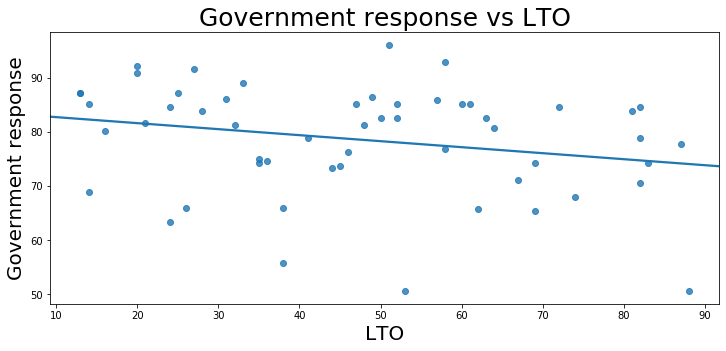

In [10]:
plt.figure(figsize=(12, 5))
plt.title("Government response vs LTO", size=25)
sns.regplot(x="ltowvs", y="GovernmentResponseIndex", data=df_merged2, ci=None)
plt.xlabel("LTO", size=20)
plt.ylabel("Government response", size=20)

- Countries with high "ivr" also implement less restrictions
- IVR stands for indulgence vs restraint, a higher value indicates a more indulgent society
- This also makes sense, more indulgent societies are less likely to be restricted
- However, simply plotting ivr against the GovernmentResponseIndex, the effect is less clear

- We also ran regressions with stringency and containment health indexes as responses
- Results mostly co-indicde, final models contain both ivr and ltowvs with negative coefficients, however, only ltowvs has a significant coefficients

Text(0, 0.5, 'Government response')

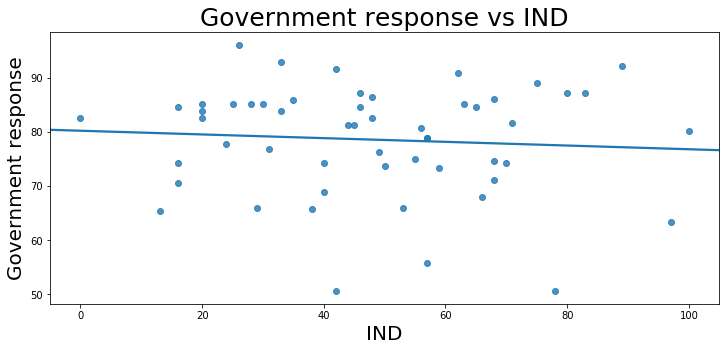

In [11]:
plt.figure(figsize=(12, 5))
plt.title("Government response vs IND", size=25)
sns.regplot(x="ivr", y="GovernmentResponseIndex", data=df_merged2, ci=None)
plt.xlabel("IND", size=20)
plt.ylabel("Government response", size=20)

### Translation to higher death rate or lower recovery rate

- Despite less government policies associated with ltowvs, there isn't a significant increase in the death rate in these countries
- Interestingly, "idv" has a significant positive coefficient, indicating that more individualistic countries suffer from a higher death rate
- Good reminder that we should help each other out in times of crisis, rather than isolating by ourselvesm

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Death rate vs IDV", size=25)
sns.regplot(x="idv", y="death_rate", data=df_merged2, ci=None)
plt.xlabel("IDV", size=20)
plt.ylabel("Death rate", size=20)